# CT Haemorrhage Prediction

We will primarily be using the fast.ai library built on top of pytorch. This script should be used on a machine with a GPU.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate
from pathlib import Path
import re

In [3]:
# A new version of PyTorch as been very recently released triggering a bunch of deprecation warnings.
# We will just turn them off for the time being until the fastai codebase gets updated to use Pytorch 1.4.0
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.functional")

In [4]:
path = Path('/home/jupyter/tutorials/data/behold')

## Preprocessing

Let's take a look at the the csv file containing our labels. 

In [5]:
df = pd.read_csv(path/'behold_coding_challenge_train.csv',index_col=0)

In [6]:
print(len(df))
df.head()

8542


,ID,epidural,intraparenchymal,subarachnoid
0,train_0,1,0,1
1,train_1,1,0,0
2,train_2,1,0,1
3,train_3,1,0,1
4,train_4,1,0,0


Let's modify it to get it into the format that we need for multilabel classification. We will concatenate all the labels into a new feature. Any instances which don't have any labels will be labelled as `normal` yielded us 4 different labels.

In [7]:
df.loc[df.epidural == 1, 'epidural'] = "epidural"
df.loc[df.intraparenchymal == 1, 'intraparenchymal'] = "intraparenchymal"
df.loc[df.subarachnoid == 1, 'subarachnoid'] = "subarachnoid"
df = df.replace(0, "")

In [8]:
df['tag'] = df['epidural'].astype(str) + " " + df['intraparenchymal'] + " " + df['subarachnoid']
df.tag = df.tag.str.strip()
df = df.drop(columns=['epidural', 'intraparenchymal', 'subarachnoid'])
df.tag = df.tag.replace("", "normal")

In [9]:
def fix_whitespace(text):
    return re.sub('\s+', ' ', text).strip()

In [10]:
df.tag = df.tag.apply(fix_whitespace)

Let's save this as a new csv file and use it to label our images when we create a `DataBunch`.

In [11]:
df.to_csv(path/"labels.csv",index=False)

In [12]:
df = pd.read_csv(path/'labels.csv')
df

,ID,tag
0,train_0,epidural subarachnoid
1,train_1,epidural
2,train_2,epidural subarachnoid
3,train_3,epidural subarachnoid
4,train_4,epidural
...,...,...
8537,train_8588,normal
8538,train_8589,normal
8539,train_8590,normal
8540,train_8591,normal


Here we set up our `DataBunch` using the `ImageList` API. We take the labels from our new csv file and allocate 20% of our training data to be validation data. We also define an image transformation function for performing data augmentation and normalize our data to have the same stats as ImageNet as we will be initially using models pretrained on ImageNet. Lastly, we set our image size to 128 x 128. All of our images are this size ensuring which makes things easier and ensures we are using every pixel.

Having looked at the images we have been given, it is clear they are not very uniform, the head can pointed in any direction and is often not in the centre of the image. Furthermore, the image is often quite zoomed out with a lot of blackspace around the edges. For these reasons, we will ensure our augmentation flips the images in all directions and zooms up to 20%.

In [13]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.2, max_warp=0.)

In [14]:
np.random.seed(42)
src = (ImageList.from_csv(path, 'labels.csv', folder='train_images', suffix='.png')
       .split_by_rand_pct(0.2)
       .label_from_df(label_delim=' ')
       .add_test_folder(path/'test_images'))

In [15]:
data = (src.transform(tfms, size=128)
        .databunch().normalize(imagenet_stats))

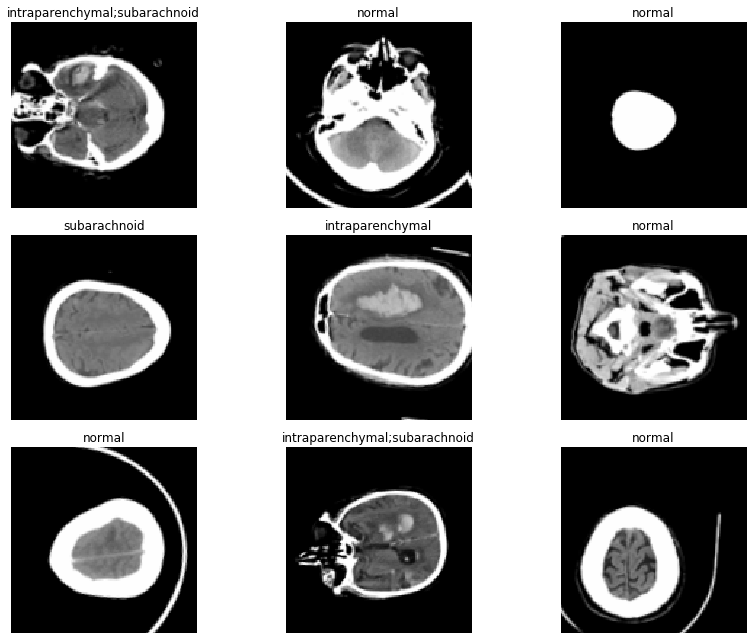

In [16]:
data.show_batch(rows=3, figsize=(12,9))

Everything looks good, let's move on to training our first model.

## Training

### Resnet34 prototype

In [17]:
defaults.device = torch.device('cuda')

In [18]:
arch = models.resnet34

In [19]:
acc_02 = partial(accuracy_thresh, thresh=0.2)

In [20]:
fbeta_multi = MultiLabelFbeta(thresh=0.2, average='micro')

In [21]:
learn = cnn_learner(data, arch, metrics=[acc_02, fbeta_multi])

In [22]:
learn.data.classes # ensure our classes are as expected

['epidural', 'intraparenchymal', 'normal', 'subarachnoid']

We report accuracy and F1 metrics on our validation set as we train our model. After some experimentation, we set the probability threshold for a prediction to be classified as correct to be > 0.2.

In [23]:
learn.model.cuda();

We use the LR Finder to pick a good learning rate.

In [23]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


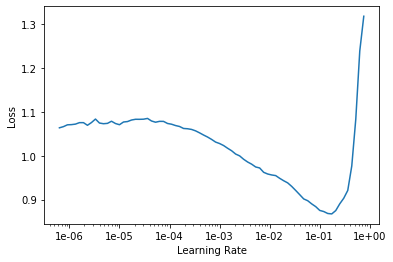

In [24]:
learn.recorder.plot()

Then we can fit the head of our network. We choose the learning rate based on the graph above opting for the area with the steepest gradient before using the `fit_one_cycle` method which optimises the training by adapting the value of the learning rate for each model weight

In [24]:
lr = 0.02

In [25]:
learn.fit_one_cycle(10, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,multi_label_fbeta,time
0,0.606401,0.475744,0.745170,0.715866,00:21
1,0.479666,0.469557,0.745170,0.740522,00:11
2,0.438295,0.404535,0.723800,0.779000,00:11
3,0.395826,0.385982,0.749561,0.785073,00:11
4,0.377353,0.393910,0.782933,0.774057,00:11
5,0.362082,0.358069,0.784543,0.797174,00:11
6,0.350362,0.358306,0.758636,0.800675,00:11
7,0.341008,0.349117,0.787324,0.802896,00:11
8,0.328920,0.356042,0.794936,0.797055,00:11
9,0.329529,0.348497,0.790545,0.802339,00:11


In [26]:
learn.save('stage-1-rn34')

Accuracy and F1 scores both ~0.8 - not a bad result for a prototype built on top of resnet-34 without even unfreezing any of the layers. Let's save this and carry on

### Fine tuning

Let's take the model that we just trained the head of and unfreeze it and train the rest of the layers.

In [27]:
learn.load('stage-1-rn34');

In [28]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


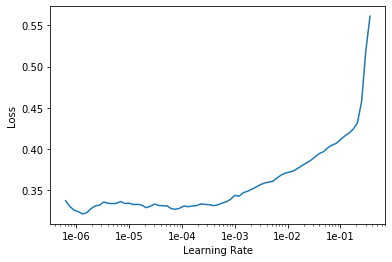

In [29]:
learn.lr_find()
learn.recorder.plot()

We will use the above graph to help choose our learning rates. We will choose one learning rate for the earlier layers and one for the later layers. The layers in between will have a learning rate that gradually goes from one to the other. This is because we don't want to update the earlier layers too much as they find fundamental things like edges and corners which are generally fundamentally present. The later layers however encode higher level objects which we will want to update a bit more.

In [30]:
learn.fit_one_cycle(10, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,accuracy_thresh,multi_label_fbeta,time
0,0.331104,0.353785,0.791130,0.798901,00:16
1,0.323165,0.346732,0.791423,0.804330,00:16
2,0.327745,0.355526,0.795228,0.798768,00:16
3,0.321855,0.344667,0.790837,0.801555,00:16
4,0.316992,0.345195,0.795814,0.805920,00:16
5,0.312727,0.345472,0.794204,0.801064,00:16
6,0.309493,0.345037,0.796253,0.803342,00:16
7,0.308539,0.339979,0.793472,0.803187,00:16
8,0.306590,0.340591,0.792447,0.803604,00:16
9,0.303054,0.340392,0.793472,0.803187,00:16


In [31]:
learn.save('stage-2-rn34')

This has eeked out a tiny improvement in performance but it's not much. Let's take a look at what our model is doing wrong:

### Results

In [33]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

395 misclassified samples over 1708 samples in the validation set.


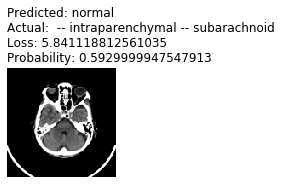

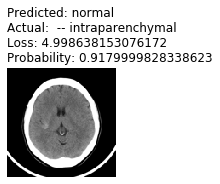

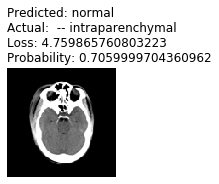

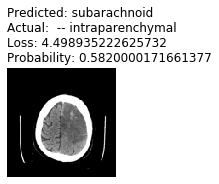

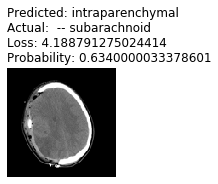

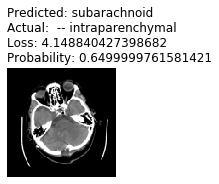

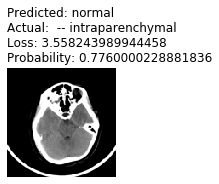

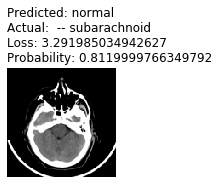

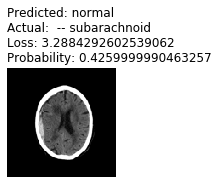

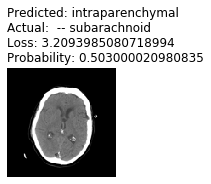

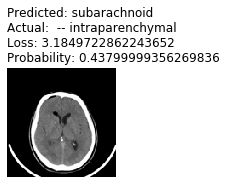

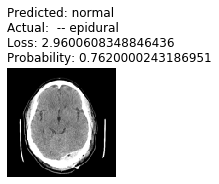

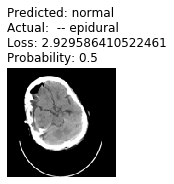

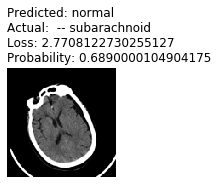

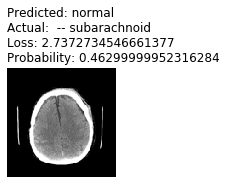

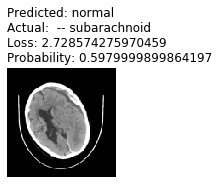

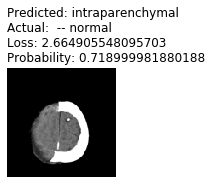

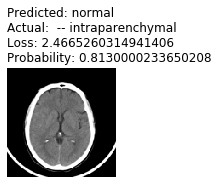

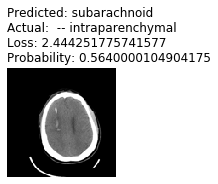

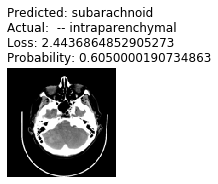

In [38]:
interp.plot_multi_top_losses(20, figsize=(2,2))

As a layman, there doesn't seem to be any obvious issues with the images our model is most wrong about. So we will just continue. Let's compute the ROC_AUC score. ROC is a probability curve and AUC represents the degree of separability the our model is capable of at various threshold settings. The closer the AUC is to 1, the better the model is at accurately distinguishing between our classes.

In [58]:
from sklearn.metrics import roc_auc_score

In [88]:
def compute_auc(learn):
    auc_scores = []
    
    val_preds,val_targets = learn.get_preds()
    preds = pd.DataFrame([t.numpy() for t in val_preds], columns = learn.data.classes)
    targets = pd.DataFrame([t.numpy() for t in val_targets], columns = learn.data.classes)
    
    for i in range(preds.shape[1]):
        auc_scores.append(roc_auc_score(list(targets.iloc[:,i]), list(preds.iloc[:,i])))
    
    print("Mean AUC:", np.mean(auc_scores))
    return dict(zip(learn.data.classes, auc_scores))

In [89]:
compute_auc(learn)

Mean AUC: 0.8635733350831284


{'epidural': 0.7858535681186284,
 'intraparenchymal': 0.895825758073584,
 'normal': 0.9334016788988071,
 'subarachnoid': 0.8392123352414945}

It seems like our model is best at being able to identify normal scans and worst at epidural followed by subarachnoid haemorrhages.

In [117]:
df_summary = df.groupby('tag').count()
df_summary.ID.nlargest(10)

tag
normal                                    3463
intraparenchymal                          1873
subarachnoid                              1654
intraparenchymal subarachnoid             1211
epidural                                   180
epidural intraparenchymal                   68
epidural subarachnoid                       53
epidural intraparenchymal subarachnoid      40
Name: ID, dtype: int64

As suspected, the performance of our model corresponds directly to the number of examples we have of each class. Epidural haemorrhages in particular or severely underrepresented. Let's try upsampling all our epidural instances (including ones where there are multiple labels) by a factor of 10 and training from scratch like before:

### Upsampling and re-training